In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL #讀取路徑圖片用
import tensorflow as tf
import pathlib #讀取資料集用

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


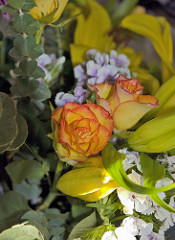

In [ ]:
roses = list(data_dir.glob('roses/*')) #讀取玫瑰花圖片
PIL.Image.open(str(roses[1]))

In [ ]:
#設定圖片參數
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#拆20,80
#訓練
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
#驗證
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
#種類 （['雛菊'，'蒲公英'，'玫瑰'，'向日葵'，'鬱金香']）
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


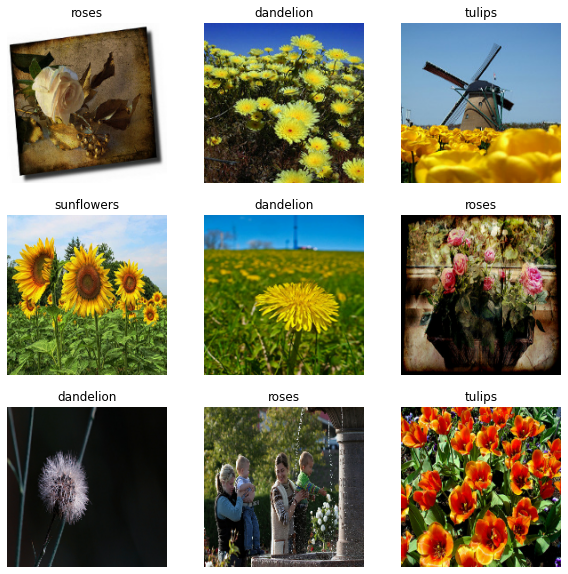

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#建立運算參數
#自動產生緩存的最佳參數
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#圖像只有[0,255]，我們把它轉為[0,1]方便運算
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# 將像素改為[0,1]
print(np.min(first_image), np.max(first_image)) 

0.0 0.9991613


In [ ]:
#建立模型
model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'), #padding='same'輸入和輸出的大小一樣
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 10s 37ms/step - loss: 1.5577 - accuracy: 0.2921 - val_loss: 1.2327 - val_accuracy: 0.4496
Epoch 2/10
92/92 [==============================] - 1s 14ms/step - loss: 1.0413 - accuracy: 0.5815 - val_loss: 0.9574 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 1s 14ms/step - loss: 0.8497 - accuracy: 0.6729 - val_loss: 0.8850 - val_accuracy: 0.6580
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.6062 - accuracy: 0.7774 - val_loss: 0.9935 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.4126 - accuracy: 0.8522 - val_loss: 1.0323 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 1s 14ms/step - loss: 0.2381 - accuracy: 0.9241 - val_loss: 1.2990 - val_accuracy: 0.6540
Epoch 7/10
92/92 [==============================] - 1s 14ms/step - loss: 0.1347 - accuracy: 0.9645 - val_loss: 1.5156 - val_accuracy: 0.6253
Epoch 8/10
9

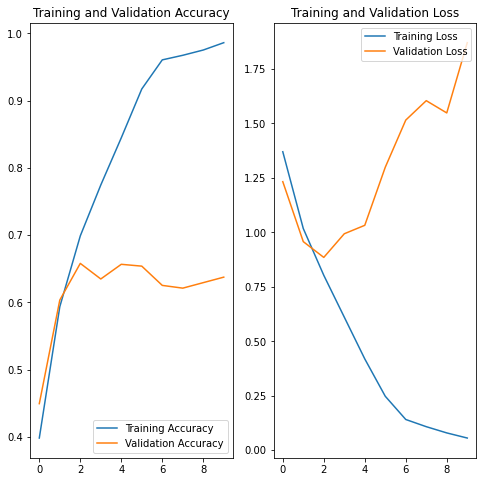

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#資料增強

In [ ]:
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",  #水平翻轉
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1), #隨機旋轉比例
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.5), #隨機縮放大小
  ]
)

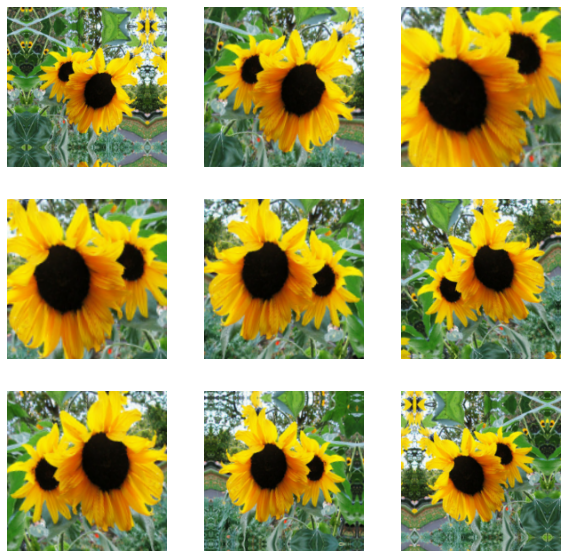

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#重新建立模型
model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 20ms/step - loss: 1.4889 - accuracy: 0.3654 - val_loss: 1.1060 - val_accuracy: 0.5518
Epoch 2/15
92/92 [==============================] - 2s 18ms/step - loss: 1.0590 - accuracy: 0.5726 - val_loss: 0.9667 - val_accuracy: 0.6172
Epoch 3/15
92/92 [==============================] - 2s 18ms/step - loss: 0.9594 - accuracy: 0.6307 - val_loss: 1.0297 - val_accuracy: 0.6117
Epoch 4/15
92/92 [==============================] - 2s 18ms/step - loss: 0.8671 - accuracy: 0.6486 - val_loss: 0.8614 - val_accuracy: 0.6540
Epoch 5/15
92/92 [==============================] - 2s 18ms/step - loss: 0.8073 - accuracy: 0.6875 - val_loss: 0.9321 - val_accuracy: 0.6390
Epoch 6/15
92/92 [==============================] - 2s 18ms/step - loss: 0.7837 - accuracy: 0.6950 - val_loss: 0.7770 - val_accuracy: 0.7071
Epoch 7/15
92/92 [==============================] - 2s 18ms/step - loss: 0.7010 - accuracy: 0.7231 - val_loss: 0.7492 - val_accuracy: 0.7084
Epoch 8/15
92

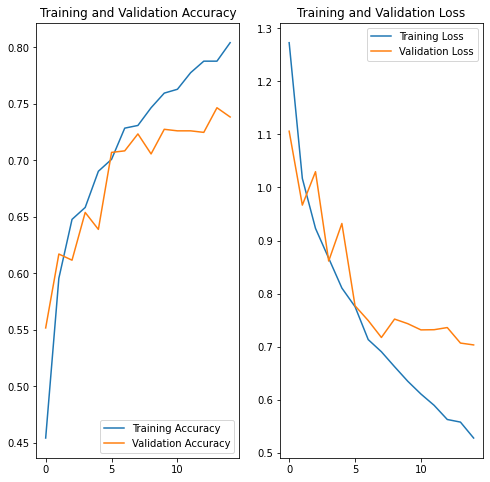

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()